In [1]:
# library(reshape)
library(ggthemes)
library(ggplot2)
library(dplyr)
library(tidyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
mashr_dir = "/hps/nobackup/hipsci/scratch/GTEx/MASHR_OUT/Anna_Neuro/"

In [3]:
list.files(mashr_dir)

[1] "MASHR_local_false_sign_rate_NeuroSeq.txt"           
[2] "MASHR_pairwise_sharing_F0.05_same_sign_NeuroSeq.txt"
[3] "MASHR_pairwise_sharing_same_sign_NeuroSeq.txt"      
[4] "MASHR_posterior_mean_NeuroSeq.txt"                  
[5] "MASHR_posterior_standard_deviation_NeuroSeq.txt"    
[6] "MASHR_Results.OriginalCovariance.NeuroSeq.Rdata"    
[7] "MASHR_significant_effects_NeuroSeq.txt"

In [4]:
sign_res = paste0(mashr_dir,"MASHR_local_false_sign_rate_NeuroSeq.txt")
mean_beta = paste0(mashr_dir,"MASHR_posterior_mean_NeuroSeq.txt")
# std_beta = paste0(mashr_dir,"MASHR_posterior_standard_deviation_sc_brain.txt")

In [5]:
##Functions
reorder_cormat <- function(cormat){
  # Use correlation between variables as distance
  dd <- as.dist((1-cormat)/2)
  hc <- hclust(dd,method="complete")
  cormat <-cormat[hc$order, hc$order]
}

In [6]:
get_upper_tri <- function(cormat){
  cormat[upper.tri(cormat)]<- NA
  return(cormat)
}

In [7]:
# local false sign rate (lfsr)
lfsrMat = read.delim(sign_res,as.is=T, row.names=1)
posteriorMean = read.delim(mean_beta,as.is=T, row.names=1)

In [8]:
nrow(lfsrMat)
ncol(lfsrMat)

[1] 9641

[1] 14

In [9]:
colnames(lfsrMat)

[1] "Neuro.pool1_13_noddd_D11.FPP"   "Neuro.pool1_13_noddd_D11.P_FPP"
 [3] "Neuro.pool1_13_noddd_D30.Astro" "Neuro.pool1_13_noddd_D30.DA"   
 [5] "Neuro.pool1_13_noddd_D30.Epen1" "Neuro.pool1_13_noddd_D30.Sert" 
 [7] "Neuro.pool1_17_D52.ROT.Astro"   "Neuro.pool1_17_D52.ROT.DA"     
 [9] "Neuro.pool1_17_D52.ROT.Epen1"   "Neuro.pool1_17_D52.ROT.Sert"   
[11] "Neuro.pool1_17_D52.Astro"       "Neuro.pool1_17_D52.DA"         
[13] "Neuro.pool1_17_D52.Epen1"       "Neuro.pool1_17_D52.Sert"

In [10]:
head(lfsrMat,2)

,Neuro.pool1_13_noddd_D11.FPP,Neuro.pool1_13_noddd_D11.P_FPP,Neuro.pool1_13_noddd_D30.Astro,Neuro.pool1_13_noddd_D30.DA,Neuro.pool1_13_noddd_D30.Epen1,Neuro.pool1_13_noddd_D30.Sert,Neuro.pool1_17_D52.ROT.Astro,Neuro.pool1_17_D52.ROT.DA,Neuro.pool1_17_D52.ROT.Epen1,Neuro.pool1_17_D52.ROT.Sert,Neuro.pool1_17_D52.Astro,Neuro.pool1_17_D52.DA,Neuro.pool1_17_D52.Epen1,Neuro.pool1_17_D52.Sert
1_10003457_G_C-ENSG00000173614,0.0006040145,0.001786852,0.0006551525,0.00258465,0.008236295,6.183711e-04,0.002368163,0.08873411,0.0008797272,2.943990e-04,0.16794242,1.185161e-02,0.00175612,6.311160e-04
1_100302872_T_C-ENSG00000162688,0.4507945203,0.391163422,0.0418977856,0.02597381,0.200079852,5.902281e-07,0.001205189,0.02289986,0.0416331366,1.856957e-07,0.02531262,1.246268e-06,0.03007824,6.884493e-13


In [45]:
ratio = 2 # ratio of magnitude between 0.5 and 2 is "same signal"
lfsrThreshold = 0.1 # significance threshold
any = F       # at least one passing significance
both = T      # both passing significance
smallest = F  # smallest sample size set passing significance

In [46]:
sameSignMagnitude = matrix(0, ncol=ncol(lfsrMat), nrow=ncol(lfsrMat))# check sign thr + same sign + ratio 
sameSign = matrix(0, ncol=ncol(lfsrMat), nrow=ncol(lfsrMat))         # check sign thr + same sign
total = matrix(0, ncol=ncol(lfsrMat), nrow=ncol(lfsrMat))            # check only sign threshold

In [47]:
options(warn=2)
if(sum(any, both, smallest)==1){
  for(colN in 1:ncol(lfsrMat)){
    for(colM in colN:ncol(lfsrMat)){
      if(any){
        toConsider = unique(c(which(lfsrMat[,colN]<lfsrThreshold),which(lfsrMat[,colM]<lfsrThreshold)))
      } else if(both) {
        toConsider = intersect(which(lfsrMat[,colN]<lfsrThreshold),which(lfsrMat[,colM]<lfsrThreshold))
      } else if(smallest){
        if(sampleSizeTissues$n[colN] > sampleSizeTissues$n[colM]){
          toConsider = which(lfsrMat[,colM]<lfsrThreshold)
        } else {
          toConsider = which(lfsrMat[,colN]<lfsrThreshold)
        }
      }
      total[colN,colM] = length(toConsider)
      total[colM,colN] = total[colN,colM]
      
      tmpInfo = posteriorMean[toConsider,colN]/posteriorMean[toConsider,colM] # check sign
      tmpInfo2 = tmpInfo[which(tmpInfo>0)]
      sameSign[colN,colM] = length(tmpInfo2)
      sameSign[colM,colN] = sameSign[colN,colM]
      
      tmpInfo2[which(tmpInfo2<1)] = 1/tmpInfo2[which(tmpInfo2<1)] # check magn ratio
      sameSignMagnitude[colN,colM] = length(which(tmpInfo2<=ratio))
      sameSignMagnitude[colM,colN] = sameSignMagnitude[colN,colM]
    }
  }
} else {
  print("Setting issue.")
}

In [48]:
# options(warn=1)

pairwiseSharingSign = sameSign/total # get fraction
pairwiseSharing = sameSignMagnitude/total

colnames(pairwiseSharing) = colnames(lfsrMat)
rownames(pairwiseSharing) = colnames(lfsrMat)
colnames(pairwiseSharingSign) = colnames(lfsrMat)
rownames(pairwiseSharingSign) = colnames(lfsrMat)

## Sign and magnitude
# upper_tri <- get_upper_tri(reorder_cormat(as.matrix(pairwiseSharing)))
## Sign only
# upper_tri <- get_upper_tri(reorder_cormat(as.matrix(pairwiseSharingSign)))
# melted_cormat <- melt(upper_tri, na.rm = TRUE)
# head(melted_cormat)

In [49]:
mat_to_plot = pairwiseSharingSign
mat_to_plot = pairwiseSharing
mat_to_plot

,Neuro.pool1_13_noddd_D11.FPP,Neuro.pool1_13_noddd_D11.P_FPP,Neuro.pool1_13_noddd_D30.Astro,Neuro.pool1_13_noddd_D30.DA,Neuro.pool1_13_noddd_D30.Epen1,Neuro.pool1_13_noddd_D30.Sert,Neuro.pool1_17_D52.ROT.Astro,Neuro.pool1_17_D52.ROT.DA,Neuro.pool1_17_D52.ROT.Epen1,Neuro.pool1_17_D52.ROT.Sert,Neuro.pool1_17_D52.Astro,Neuro.pool1_17_D52.DA,Neuro.pool1_17_D52.Epen1,Neuro.pool1_17_D52.Sert
Neuro.pool1_13_noddd_D11.FPP,1.0000000,0.9823589,0.8289132,0.7603950,0.7972376,0.7784679,0.7887749,0.7744270,0.7947230,0.7194920,0.7269327,0.7588424,0.7622863,0.7431488
Neuro.pool1_13_noddd_D11.P_FPP,0.9823589,1.0000000,0.8111406,0.7313830,0.7790894,0.7517205,0.7769653,0.7696078,0.7838710,0.7168641,0.7185515,0.7505470,0.7608932,0.7250274
Neuro.pool1_13_noddd_D30.Astro,0.8289132,0.8111406,1.0000000,0.9256198,0.9651339,0.9456731,0.8810069,0.8528389,0.9412336,0.7941788,0.9148695,0.8879440,0.9498783,0.8617234
Neuro.pool1_13_noddd_D30.DA,0.7603950,0.7313830,0.9256198,1.0000000,0.8323790,0.9541371,0.7651471,0.9215247,0.8386296,0.7265264,0.8083382,0.9624096,0.8228228,0.8028656
Neuro.pool1_13_noddd_D30.Epen1,0.7972376,0.7790894,0.9651339,0.8323790,1.0000000,0.8939472,0.8617647,0.8261682,0.9588766,0.8193760,0.9080393,0.8460300,0.9741422,0.8532839
Neuro.pool1_13_noddd_D30.Sert,0.7784679,0.7517205,0.9456731,0.9541371,0.8939472,1.0000000,0.8173022,0.8918919,0.9092683,0.8695652,0.8550891,0.9370765,0.9051131,0.9487909
Neuro.pool1_17_D52.ROT.Astro,0.7887749,0.7769653,0.8810069,0.7651471,0.8617647,0.8173022,1.0000000,0.8262880,0.9059544,0.8448786,0.9245636,0.8165888,0.8745031,0.8388025
Neuro.pool1_17_D52.ROT.DA,0.7744270,0.7696078,0.8528389,0.9215247,0.8261682,0.8918919,0.8262880,1.0000000,0.8366511,0.8413349,0.8288227,0.9645626,0.8279762,0.8614943
Neuro.pool1_17_D52.ROT.Epen1,0.7947230,0.7838710,0.9412336,0.8386296,0.9588766,0.9092683,0.9059544,0.8366511,1.0000000,0.8590535,0.9026048,0.8578706,0.9789775,0.8901590
Neuro.pool1_17_D52.ROT.Sert,0.7194920,0.7168641,0.7941788,0.7265264,0.8193760,0.8695652,0.8448786,0.8413349,0.8590535,1.0000000,0.8007313,0.8498701,0.8414189,0.9737609


In [50]:
rownames(mat_to_plot) <- c("D11_FPP", 
#                            "D11_NB", 
                           "D11_P_FPP",
                           "D30_FPP","D30_DA","D30_Epen1","D30_Sert",
                           "D52_Astro_ROT","D52_DA_ROT","D52_Epen1_ROT","D52_Sert_ROT",
                           "D52_Astro","D52_DA","D52_Epen1","D52_Sert"
                           )
colnames(mat_to_plot) = rownames(mat_to_plot)

In [51]:
library(RColorBrewer)

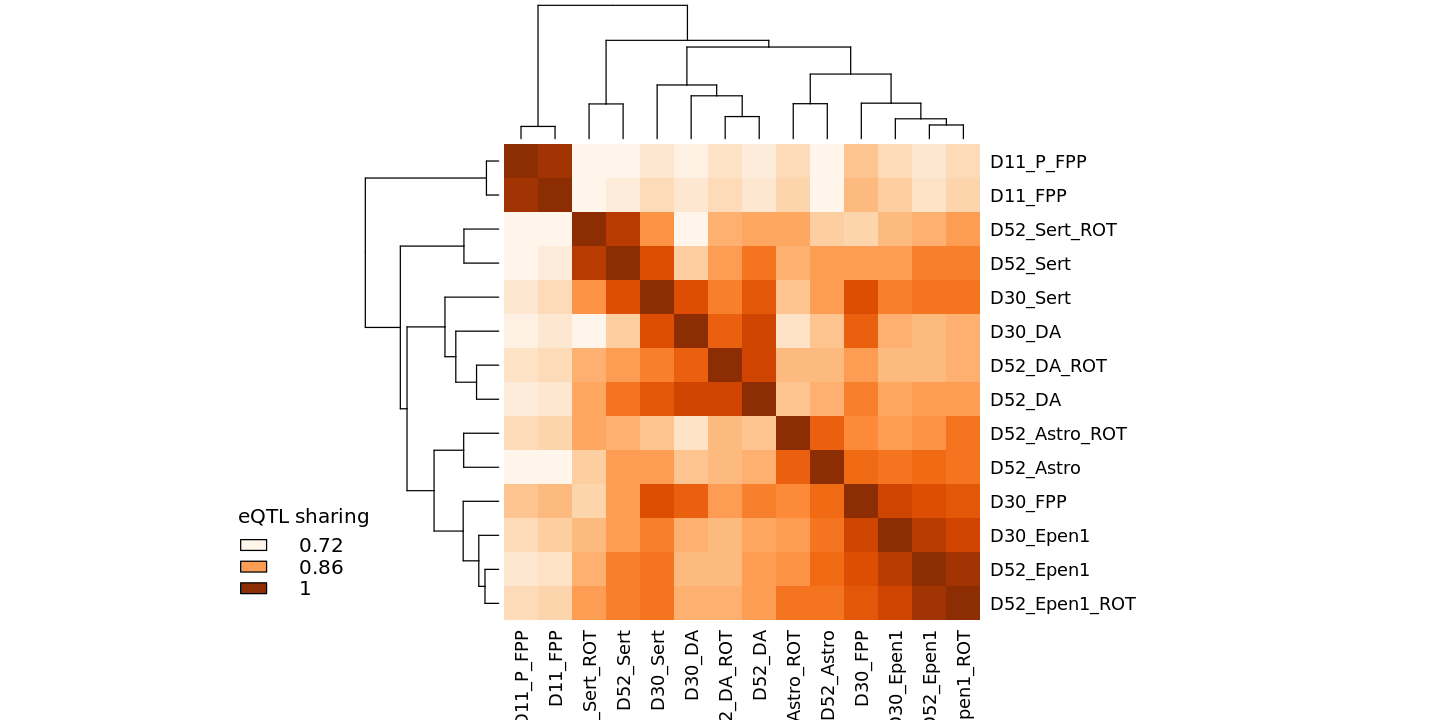

In [54]:
options(repr.plot.width=12, repr.plot.height=6)
heatmap(mat_to_plot, symm = T, col= colorRampPalette(brewer.pal(8, "Oranges"))(25))
legend(x="bottomleft", legend=c(round(min(mat_to_plot),digits = 2), 
                                round(mean(mat_to_plot),digits = 2), max(mat_to_plot)), 
       fill=colorRampPalette(brewer.pal(8, "Oranges"))(3),
      title = "eQTL sharing", bty = "n")

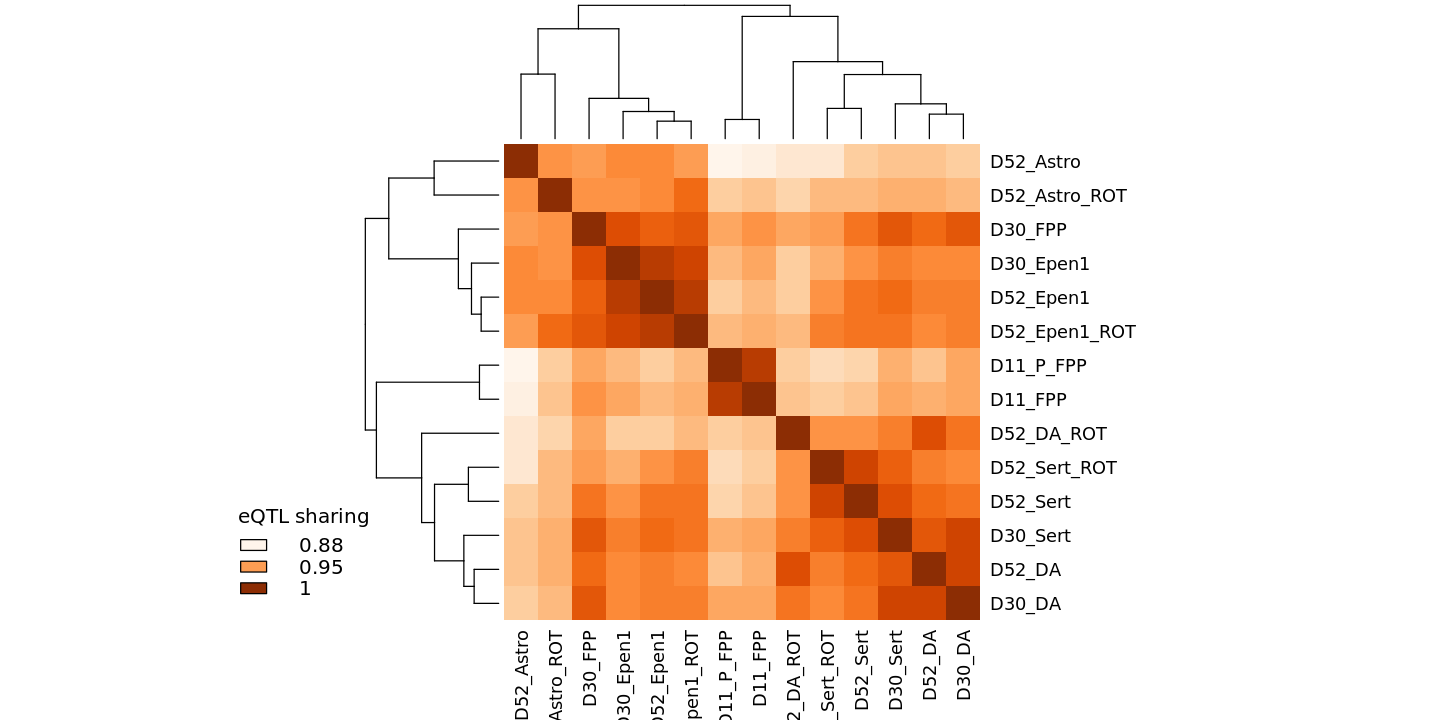

In [44]:
options(repr.plot.width=12, repr.plot.height=6)
heatmap(mat_to_plot, symm = T, col= colorRampPalette(brewer.pal(8, "Oranges"))(25))
legend(x="bottomleft", legend=c(round(min(mat_to_plot),digits = 2), 
                                round(mean(mat_to_plot),digits = 2), max(mat_to_plot)), 
       fill=colorRampPalette(brewer.pal(8, "Oranges"))(3),
      title = "eQTL sharing", bty = "n")

In [50]:
###

In [57]:
tail(lfsrMat,2)

,Neuro.pool1_13_noddd_D11.FPP,Neuro.pool1_13_noddd_D11.P_FPP,Neuro.pool1_13_noddd_D30.Astro,Neuro.pool1_13_noddd_D30.DA,Neuro.pool1_13_noddd_D30.Epen1,Neuro.pool1_13_noddd_D30.Sert,Neuro.pool1_17_D52.ROT.Astro,Neuro.pool1_17_D52.ROT.DA,Neuro.pool1_17_D52.ROT.Epen1,Neuro.pool1_17_D52.ROT.Sert,Neuro.pool1_17_D52.Astro,Neuro.pool1_17_D52.DA,Neuro.pool1_17_D52.Epen1,Neuro.pool1_17_D52.Sert
9_99919913_T_G-ENSG00000081386,0.6323487,0.5948867,0.5925978,0.5317715,0.5967328,0.6087826,0.6231248,0.4888247,0.5847321,0.4938633,0.5904548,0.5593644,0.6372348,0.4802638
9_99943245_T_A-ENSG00000136936,0.2809734,0.2834326,0.3142621,0.2855057,0.3520123,0.3630674,0.2075315,0.3205747,0.3218864,0.3897582,0.3170396,0.3038433,0.2911454,0.3763736


In [107]:
df = lfsrMat
df$how_many_maps = 0
for (i in 1:nrow(df)){
    df$how_many_maps[i] = sum(df[i,1:(ncol(df)-1)]<0.05)
}

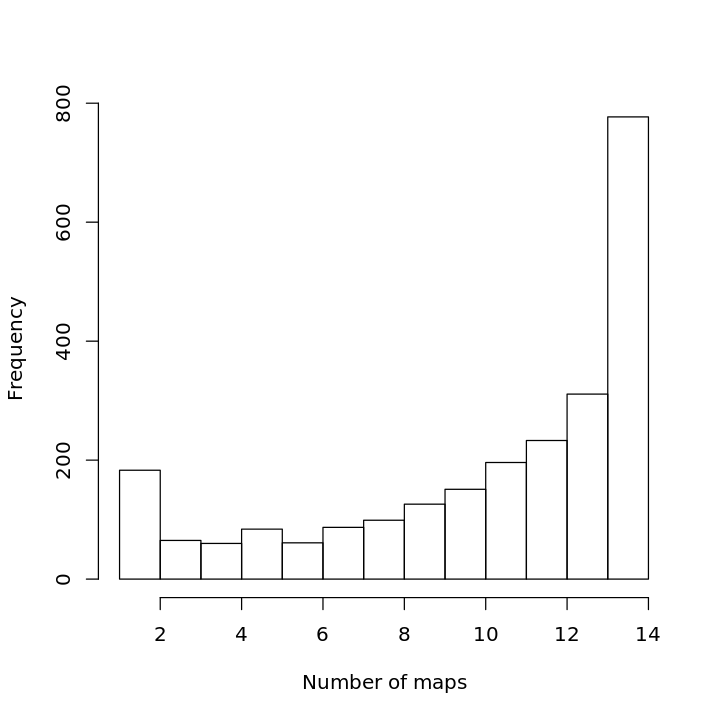

In [108]:
hist(df[df$how_many_maps>0,'how_many_maps'], breaks = 14, main = "", xlab = "Number of maps")

In [122]:
colnames(df) = c("D11_FPP","D11_P_FP","D30_FPP","D30_DA","D30_Epen1","D30_Sert",
                "D52_ROT_Astro","D52_ROT_DA","D52_ROT_Epen1","D52_ROT_Sert",
                "D52_Astro","D52_DA","D52_Epen1","D52_Sert","how_many_maps")

In [123]:
head(df,2)

,D11_FPP,D11_P_FP,D30_FPP,D30_DA,D30_Epen1,D30_Sert,D52_ROT_Astro,D52_ROT_DA,D52_ROT_Epen1,D52_ROT_Sert,D52_Astro,D52_DA,D52_Epen1,D52_Sert,how_many_maps,NA
1_10003457_G_C-ENSG00000173614,0.0006040145,0.001786852,0.0006551525,0.00258465,0.008236295,6.183711e-04,0.002368163,0.08873411,0.0008797272,2.943990e-04,0.16794242,1.185161e-02,0.00175612,6.311160e-04,12,7
1_100302872_T_C-ENSG00000162688,0.4507945203,0.391163422,0.0418977856,0.02597381,0.200079852,5.902281e-07,0.001205189,0.02289986,0.0416331366,1.856957e-07,0.02531262,1.246268e-06,0.03007824,6.884493e-13,11,5


In [124]:
celltypes = c("FPP","P_FP","DA","Sert","Epen1","Astro")
# df = lfsrMat
df$how_many_cell_types = 0
for (i in 1:nrow(df)){
    k = 0
    for (celltype in celltypes){
        if (sum(df[i,grep(celltype, colnames(df))]<0.05)>0){k = k+1}
    }
    df$how_many_cell_types[i] = k
}

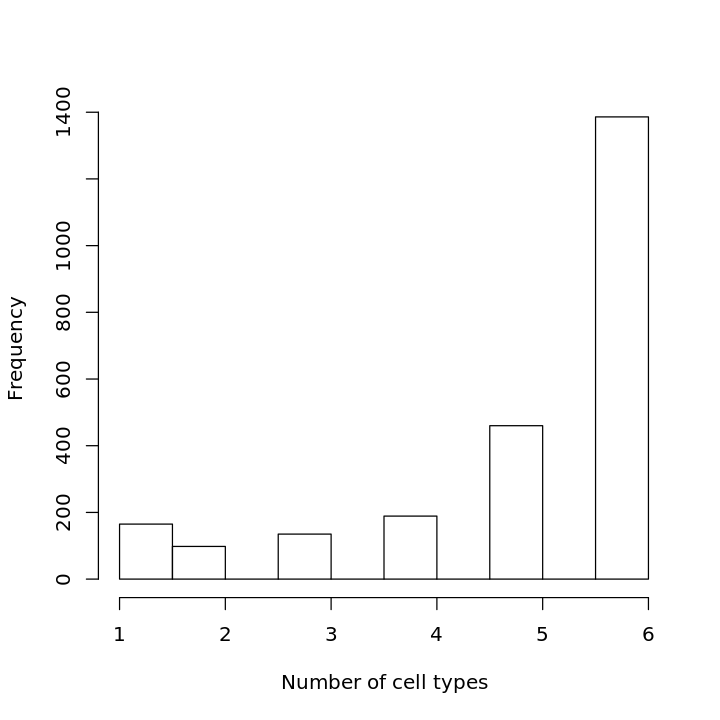

In [128]:
hist(df[df$how_many_cell_types>0,'how_many_cell_types'], breaks = 10, main = "", xlab = "Number of cell types")